# XGBoost in Depth

## Core Concepts

### Gradient Boosting

- Gradient Boosting is an ensemble technique that builds models sequentially. Each new model attempts to correct the errors made by the previous models.
- Instead of adjusting the weights of incorrectly classified samples, as in AdaBoost, gradient boosting fits the new model to the residual errors made by the previous model.

### Decision Trees

- XGBoost uses decision trees as base learners. It builds trees in a greedy manner, adding splits to improve the model’s performance.

## Key Features of XGBoost

### Regularization

- L1 (Lasso Regression) and L2 (Ridge Regression) regularization are used to avoid overfitting. This is controlled by the parameters `reg_alpha` and `reg_lambda`.

### Weighted Quantile Sketch

- XGBoost uses a special algorithm to handle weighted data in the quantile sketch, which improves its efficiency and scalability.

### Sparsity Awareness

- It can handle sparse data efficiently through a sparsity-aware split finding algorithm.

### Handling Missing Values

- XGBoost can handle missing values internally without needing preprocessing.

### Parallel and Distributed Computing

- It can perform computations in parallel on a single machine, and it can also be distributed across multiple machines.

### Scalability

- XGBoost is optimized for speed and memory efficiency, making it suitable for large datasets.

## Parameters

Here are some important parameters in XGBoost:

### Booster Parameters

- `booster`: Specifies the type of model to be used (e.g., `gbtree`, `gblinear`).
- `n_estimators`: Number of boosting rounds.
- `learning_rate` (`eta`): Step size shrinkage to prevent overfitting.
- `max_depth`: Maximum depth of the tree.
- `min_child_weight`: Minimum sum of instance weight (hessian) needed in a child.
- `subsample`: Fraction of samples to be used for fitting the individual base learners.
- `colsample_bytree`: Fraction of features to be used for each tree.
- `reg_alpha`: L1 regularization term on weights.
- `reg_lambda`: L2 regularization term on weights.
- `gamma`: Minimum loss reduction required to make a further partition on a leaf node.

### Learning Task Parameters

- `objective`: Specifies the learning task and the corresponding objective function (e.g., `reg:squarederror` for regression).
- `eval_metric`: Evaluation metric (e.g., `rmse`, `mae`, `logloss`).

## Working of XGBoost

### Initialization

- Start with an initial prediction, usually the mean of the target values for regression or the log-odds for classification.

### Calculate Residuals

- Compute the residuals (errors) of the current predictions.

### Fit a Decision Tree

- Fit a decision tree to the residuals. The tree’s objective is to minimize the loss function (e.g., mean squared error).

### Calculate Predictions

- Update the predictions by adding the scaled output of the new tree (scaled by `learning_rate`).

### Update Residuals

- Compute the new residuals using the updated predictions.

### Repeat

- Repeat steps 3 to 5 for the specified number of boosting rounds (`n_estimators`).

## Advanced Features

### Tree Pruning

- Unlike traditional decision trees, XGBoost uses a maximum depth parameter to control the tree size and prevent overfitting.

### Cross-Validation

- XGBoost can perform cross-validation internally during training.

### Early Stopping

- If a validation metric stops improving, the training can be stopped early to prevent overfitting.

### Feature Importance

- XGBoost provides ways to compute feature importance, which helps in understanding the model.


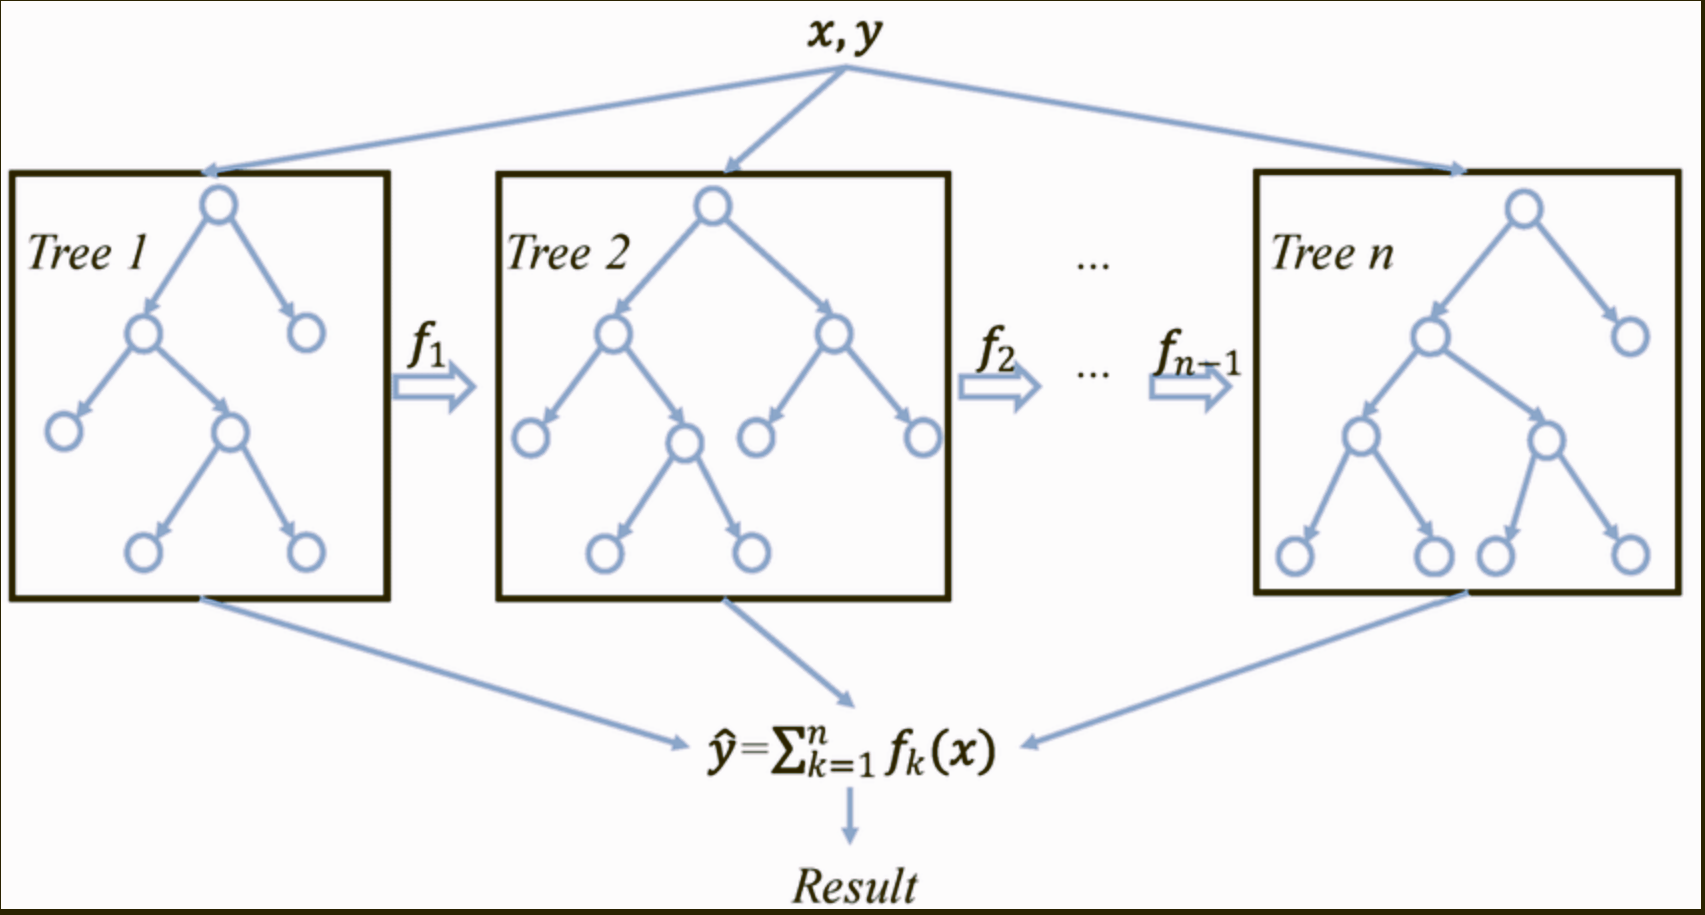


In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class TreeNode:
    def __init__(self, depth=0, max_depth=3, reg_lambda=1, gamma=0):
        self.depth = depth
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.left = None
        self.right = None
        self.feature_index = None
        self.split_value = None
        self.value = None

    def calculate_similarity_score(self, residuals):
        return np.sum(residuals) ** 2 / (len(residuals) + self.reg_lambda)

    def calculate_gain(self, left_residuals, right_residuals):
        parent_score = self.calculate_similarity_score(np.concatenate((left_residuals, right_residuals)))
        left_score = self.calculate_similarity_score(left_residuals)
        right_score = self.calculate_similarity_score(right_residuals)
        gain = 0.5 * (left_score + right_score - parent_score) - self.gamma
        return gain

    def fit(self, X, residuals):
        if self.depth >= self.max_depth or len(X) <= 1:
            self.value = np.mean(residuals)
            return

        best_gain = 0
        best_split = None
        for feature_index in range(X.shape[1]):
            sorted_indices = np.argsort(X[:, feature_index])
            X_sorted = X[sorted_indices]
            residuals_sorted = residuals[sorted_indices]

            for i in range(1, len(X)):
                left_residuals = residuals_sorted[:i]
                right_residuals = residuals_sorted[i:]
                gain = self.calculate_gain(left_residuals, right_residuals)
                if gain > best_gain:
                    best_gain = gain
                    best_split = (feature_index, (X_sorted[i-1, feature_index] + X_sorted[i, feature_index]) / 2)

        if best_split is not None:
            self.feature_index, self.split_value = best_split
            left_indices = X[:, self.feature_index] <= self.split_value
            right_indices = X[:, self.feature_index] > self.split_value
            self.left = TreeNode(self.depth + 1, self.max_depth, self.reg_lambda, self.gamma)
            self.right = TreeNode(self.depth + 1, self.max_depth, self.reg_lambda, self.gamma)
            self.left.fit(X[left_indices], residuals[left_indices])
            self.right.fit(X[right_indices], residuals[right_indices])
        else:
            self.value = np.mean(residuals)

    def predict(self, X):
        if self.value is not None:
            return np.full(X.shape[0], self.value)
        left_indices = X[:, self.feature_index] <= self.split_value
        right_indices = X[:, self.feature_index] > self.split_value
        predictions = np.zeros(X.shape[0])
        predictions[left_indices] = self.left.predict(X[left_indices])
        predictions[right_indices] = self.right.predict(X[right_indices])
        return predictions

class XGBoostRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1, gamma=0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.trees = []
        self.mean_y = 0

    def fit(self, X, y):
        self.mean_y = np.mean(y)
        y_pred = np.full(y.shape, self.mean_y)
        for _ in range(self.n_estimators):
            residuals = y - y_pred
            tree = TreeNode(max_depth=self.max_depth, reg_lambda=self.reg_lambda, gamma=self.gamma)
            tree.fit(X, residuals)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.trees.append(tree)

    def predict(self, X):
        y_pred = np.full((X.shape[0],), self.mean_y)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

# Load the dataset
boston = datasets.load_diabetes()
X = boston.data
y = boston.target

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
xgb = XGBoostRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, reg_lambda=1, gamma=0)
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
mse = np.sum((y_pred == y_test))
print(f'Mean Squared Error: {mse}')


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Mean Squared Error: 2656.257387937961
